In [14]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import ttest_1samp
%matplotlib inline

if '..' not in sys.path:
    sys.path.append('..')
import make_bayes_submission
from make_submission import sigmoid, logit

In [15]:
valid_pred = pd.read_hdf('../../_data/20170718-234554-b5-albu-eval.h5')
valid_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
train_0,0.004018,0.002505,0.002335,0.002023,0.001570,0.564935,0.004454,0.001158,0.002751,0.002372,0.683979,0.002067,0.997527,0.002525,0.001848,0.001840,0.003917
train_1,0.817122,0.003267,0.016906,0.001994,0.001630,0.997239,0.003767,0.001254,0.460328,0.032931,0.002022,0.002043,0.997559,0.525844,0.003418,0.016891,0.826382
train_2,0.003122,0.002086,0.002283,0.001856,0.001547,0.997508,0.004618,0.001149,0.002176,0.002374,0.001877,0.001882,0.997805,0.002592,0.001828,0.001718,0.003053


In [3]:
train_flat = pd.read_csv('../../_data/train_flat.csv', index_col=0)
train_flat[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [4]:
def f2_score(y_true, y_pred, eps=1e-7) -> float:
    # same as fbeta_score(y_true, y_pred, beta=2, average='samples')
    # but faster
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.as_matrix()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.as_matrix()
    tp = (y_true * y_pred).sum(axis=1)
    r = tp / y_true.sum(axis=1)
    p = tp / (y_pred.sum(axis=1) + eps)
    beta2 = 4
    f2 = (1 + beta2) * p * r / (beta2 * p + r + eps)
    return f2.mean()

In [57]:
threshold = 0.23
original_score = f2_score(train_flat, valid_pred > threshold)
original_score

0.93359126053359631

In [56]:
for th in np.linspace(0.15, 0.35, 100):
    score = f2_score(train_flat.as_matrix(), (valid_pred > th).as_matrix())
    if score > original_score:
        print('{:.4f} {:.7f}'.format(th, score - original_score))

0.2066 0.0000158
0.2086 0.0000110
0.2106 0.0000459
0.2126 0.0000618
0.2146 0.0001070
0.2167 0.0000879
0.2187 0.0000329
0.2207 0.0000595
0.2227 0.0000742
0.2247 0.0000740
0.2268 0.0000963
0.2288 0.0001427
0.2308 0.0001310
0.2328 0.0001640
0.2348 0.0001745
0.2369 0.0001697
0.2389 0.0001105
0.2409 0.0001061
0.2429 0.0001321
0.2449 0.0001292
0.2470 0.0000623
0.2490 0.0000502
0.2510 0.0000416
0.2530 0.0000022


Mean delta +0.00003
T-test: Ttest_1sampResult(statistic=4.0514643543311033, pvalue=5.4844563729809448e-05)


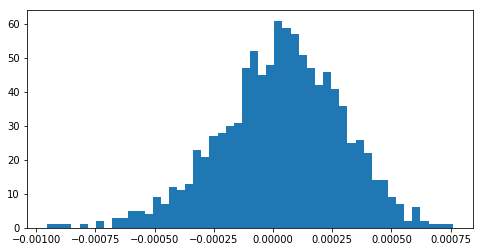

In [25]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        hack = valid_pred.iloc[valid_ids].copy()
        hack[hack['cloudy'] > .7] *= .7
        delta = (f2_score(train_flat.iloc[valid_ids], hack > threshold) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
        # print('{:+.5f}'.format(delta))
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.5f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

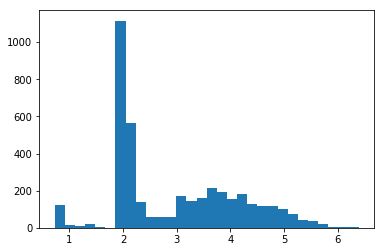

In [28]:
plt.hist(hack.as_matrix().sum(axis=1), bins=30);

In [29]:
bayes_valid = make_bayes_submission.get_df_prediction(valid_pred)

In [30]:
new_score = f2_score(train_flat, bayes_valid)
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933601, 0.000010


In [33]:
for alpha in [-0.02, -0.03, -0.05]:
    new_score = f2_score(
        train_flat,
        make_bayes_submission.get_df_prediction(valid_pred * (1 + alpha)))
    print('alpha={:.2f}, score={:.6f}, delta={:.6f}'.format(alpha, new_score, new_score - original_score))

alpha=-0.02, score=0.933596, delta=0.000005
alpha=-0.03, score=0.933625, delta=0.000034
alpha=-0.05, score=0.933664, delta=0.000072


In [35]:
for delta in [-0.05, -0.10, 0.05]:
    new_score = f2_score(
        train_flat,
        make_bayes_submission.get_df_prediction(sigmoid(logit(valid_pred) + delta)))
    print('delta={:.2f}, score={:.6f}, delta={:.6f}'.format(delta, new_score, new_score - original_score))

delta=-0.05, score=0.933657, delta=0.000066
delta=-0.10, score=0.933619, delta=0.000027
delta=0.05, score=0.933533, delta=-0.000058


In [63]:
for i in range(1000):
    if not (
        make_bayes_submission.get_item_prediction(valid_pred.iloc[i], min_p=0.03, max_p=0.5).astype(np.bool) ==
        np.array(valid_pred.iloc[i] > threshold)).all():
        break

In [65]:
item = valid_pred.iloc[i]
item

agriculture          0.921352
artisinal_mine       0.001565
bare_ground          0.019235
blooming             0.001881
blow_down            0.001724
clear                0.997640
cloudy               0.001383
conventional_mine    0.001516
cultivation          0.250852
habitation           0.879692
haze                 0.002004
partly_cloudy        0.001761
primary              0.996084
road                 0.912322
selective_logging    0.004949
slash_burn           0.002174
water                0.209797
Name: train_4, dtype: float64

In [68]:
np.array(item > threshold)

array([ True, False, False, False, False,  True, False, False,  True,
        True, False, False,  True,  True, False, False,  True], dtype=bool)

In [69]:
make_bayes_submission.get_item_prediction(item, min_p=0.03, max_p=0.5).astype(np.bool)

array([ True, False, False, False, False,  True, False, False,  True,
        True, False, False,  True,  True, False, False, False], dtype=bool)

In [36]:
new_score = f2_score(train_flat, bayes_valid)
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933267, 0.000057


In [37]:
new_score = f2_score(train_flat, make_bayes_submission.get_df_prediction(valid_pred, min_p=0.02, max_p=0.7))
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933244, 0.000035


In [45]:
new_score = f2_score(train_flat, make_bayes_submission.get_df_prediction(valid_pred, min_p=0.03, max_p=0.5))
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933270, 0.000061


Mean delta +0.000057
T-test: Ttest_1sampResult(statistic=6.1884754633871157, pvalue=8.8523569279878356e-10)


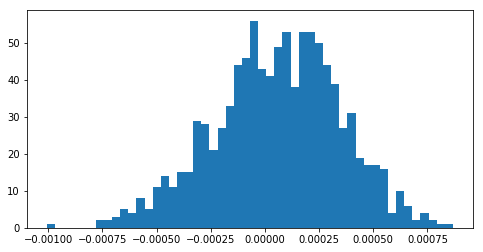

In [32]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        bayes = make_bayes_submission.get_df_prediction(valid_pred.iloc[valid_ids])
        delta = (f2_score(train_flat.iloc[valid_ids], bayes) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

Mean delta +0.000112
T-test: Ttest_1sampResult(statistic=3.3712499186743745, pvalue=0.0010683301814363732)


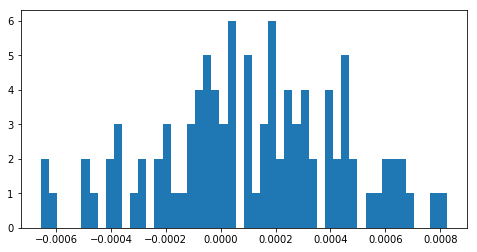

In [34]:
deltas = []
for _ in range(10):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        hack = valid_pred.iloc[valid_ids].copy()
        hack[hack['cloudy'] > .7] *= .7
        bayes = make_bayes_submission.get_df_prediction(hack)
        delta = (f2_score(train_flat.iloc[valid_ids], bayes) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [6]:
bayes_shifted = make_bayes_submission.get_df_prediction(sigmoid(logit(valid_pred) + 0.1))

Mean delta +0.000154
T-test: Ttest_1sampResult(statistic=28.651988829842661, pvalue=2.8791999077179275e-132)


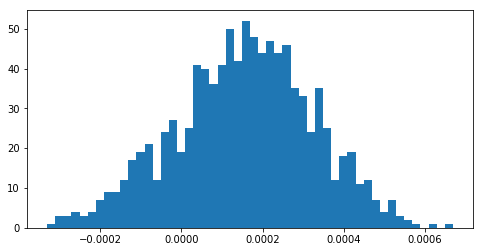

In [10]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        delta = (f2_score(train_flat.iloc[valid_ids], bayes_shifted.iloc[valid_ids]) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [69]:
hack = valid_pred.copy()
#hack[hack['cloudy'] > .7] *= .7
bayes_shifted_hack = make_bayes_submission.get_df_prediction(sigmoid(logit(hack) - 0.05))        

Mean delta +0.000058
T-test: Ttest_1sampResult(statistic=8.3901947871382649, pvalue=1.6416239430711714e-16)


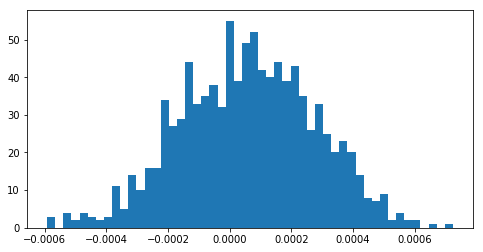

In [68]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        delta = (f2_score(train_flat.iloc[valid_ids], bayes_shifted_hack.iloc[valid_ids]) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [59]:
test_pred = pd.read_hdf('../../_data/20170718-234554-b5-albu-test.h5')
test_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
test_0,0.004113,0.002012,0.002408,0.023581,0.001611,0.995923,0.004199,0.001131,0.002835,0.002479,0.007182,0.001789,0.997718,0.002671,0.002386,0.001717,0.003171
test_1,0.016897,0.002029,0.002591,0.019749,0.031641,0.997341,0.004212,0.001136,0.012829,0.002681,0.001939,0.001869,0.997683,0.002925,0.008051,0.001788,0.003476
test_2,0.008854,0.002017,0.002369,0.001858,0.001609,0.003500,0.004229,0.001139,0.003444,0.002375,0.001906,0.995849,0.997714,0.003574,0.001877,0.001748,0.013157


In [60]:
test_hack = test_pred.copy()
#test_hack[test_hack['cloudy'] > .7] *= .7
bayes_shifted_test_hack = make_bayes_submission.get_df_prediction(sigmoid(logit(test_hack) - 0.05))        

In [61]:
bayes_shifted_test_hack[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
b'image_name',,,,,,,,,,,,,,,,,
test_0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
test_1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
test_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [62]:
out_df = pd.DataFrame([
    {'tags': ' '.join(c for c in bayes_shifted_test_hack.columns if row[c])
     } for image_name, row in bayes_shifted_test_hack.iterrows()],
    index=bayes_shifted_test_hack.index)

In [63]:
original_score + 0.000066

0.93365726053359632

In [64]:
out_df[:10]

,tags
b'image_name',
test_0,clear primary
test_1,clear primary
test_2,partly_cloudy primary
test_3,agriculture clear cultivation primary
test_4,cloudy partly_cloudy primary
test_5,clear primary
test_6,agriculture clear cultivation habitation partl...
test_7,agriculture clear habitation primary road
test_8,clear primary


In [65]:
out_df.to_csv('../../20170718-234554-b5-albu-bayesminus005-test.csv', index_label='image_name')

In [66]:
! head ../../20170718-234554-b5-albu-bayesminus005-test.csv

image_name,tags
test_0,clear primary
test_1,clear primary
test_2,partly_cloudy primary
test_3,agriculture clear cultivation primary
test_4,cloudy partly_cloudy primary
test_5,clear primary
test_6,agriculture clear cultivation habitation partly_cloudy primary water
test_7,agriculture clear habitation primary road
test_8,clear primary
